In [88]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier

In [89]:
# Load the dataset
file_path = 'TrafficStopData.csv'
traffic_data = pd.read_csv(file_path, low_memory=False).iloc[:20000]

# Drop rows with missing target values
traffic_data = traffic_data.dropna(subset=['ACTIONTAKENCID'])
traffic_data = traffic_data.drop(columns=['INCIDENT_TYPE_ID', 'LONGITUDE_X', 'FIELD_SUBJECT_CID', 'DISTRICT'])

# Encode the target variable
le = LabelEncoder()
traffic_data['ACTIONTAKENCID'] = le.fit_transform(traffic_data['ACTIONTAKENCID'])

# Separate target variable and features
target = traffic_data['ACTIONTAKENCID']
features = traffic_data.drop(columns=['ACTIONTAKENCID'])

# Handle all categorical features using Label Encoding
categorical_columns = features.select_dtypes(include=['object']).columns
for col in categorical_columns:
    le = LabelEncoder()
    features[col] = le.fit_transform(features[col].astype(str))

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)

# Define the Random Forest model
random_forest = RandomForestClassifier(random_state=42)

# Define the parameter grid for RandomizedSearchCV
param_dist = {
    'n_estimators': [50, 100, 200],  # Number of trees
    'max_depth': [5, 10, 20, None],  # Maximum tree depth
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split
    'min_samples_leaf': [1, 2, 4],  # Minimum samples required per leaf
    'criterion': ['gini', 'entropy'],  # Splitting criteria
}

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=random_forest,
    param_distributions=param_dist,
    n_iter=20,  # Number of parameter settings sampled
    scoring='accuracy',
    cv=3,  # Number of folds
    verbose=1,
    n_jobs=-1,
    random_state=42,
)

# Fit RandomizedSearchCV
random_search.fit(X_train, y_train)

# Best model
best_rf_model = random_search.best_estimator_
print("Best Parameters:", random_search.best_params_)
print("Best Cross-Validation Score:", random_search.best_score_)

# Evaluate the model on the test set
y_pred_rf = best_rf_model.predict(X_test)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 20, 'criterion': 'gini'}
Best Cross-Validation Score: 0.5073581940277183


In [90]:
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf, zero_division=1))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))

Accuracy: 0.5105
Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.54      0.52      1287
           1       0.58      0.60      0.59      1614
           2       0.51      0.69      0.59      1873
           3       0.08      0.02      0.03       157
           4       0.38      0.08      0.13       214
           5       0.15      0.04      0.07       189
           6       0.24      0.07      0.11       354
           7       0.26      0.12      0.17       254
           8       0.83      0.17      0.29        58

    accuracy                           0.51      6000
   macro avg       0.39      0.26      0.28      6000
weighted avg       0.47      0.51      0.48      6000

Confusion Matrix:
 [[ 699  293  247    3    4    7   17   17    0]
 [ 223  970  396    5    3    3    7    7    0]
 [ 225  237 1301   14   12   21   41   21    1]
 [  28   18   95    3    0    2    8    3    0]
 [  33   20  115    4   17   11    1   13  

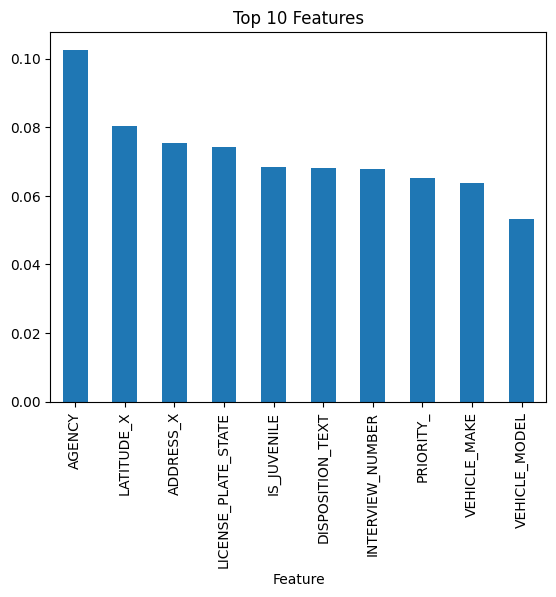

In [91]:
# Plot top 10 important features
feature_importance[:10].plot(kind='bar', x='Feature', y='Importance', title='Top 10 Features', legend=False)
plt.show()

In [92]:
# Feature importance
importances = best_rf_model.feature_importances_
feature_importance = pd.DataFrame({'Feature': features.columns, 'Importance': importances})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
print("\nFeature Importances:\n", feature_importance)


Feature Importances:
                            Feature  Importance
2                           AGENCY    0.102598
1                       LATITUDE_X    0.080385
0                        ADDRESS_X    0.075282
16             LICENSE_PLATE_STATE    0.074206
9                      IS_JUVENILE    0.068307
3                 DISPOSITION_TEXT    0.068132
10                INTERVIEW_NUMBER    0.067910
7                        PRIORITY_    0.065225
12                    VEHICLE_MAKE    0.063804
13                   VEHICLE_MODEL    0.053320
11                  INTERVIEW_DATE    0.048625
22  COMMUNITY_COUNCIL_NEIGHBORHOOD    0.036530
21                            BEAT    0.034400
24                CPD_NEIGHBORHOOD    0.034114
23                SNA_NEIGHBORHOOD    0.031093
20                   AGE_RANGE_CID    0.024211
5               INCIDENT_TYPE_DESC    0.011960
19                             SEX    0.010831
4                     EVENT_NUMBER    0.010536
18                 REPORT_TYPE_CID   

In [93]:
y_pred_labels = le.inverse_transform(y_pred)
print("Predicted class labels:", y_pred_labels)

Predicted class labels: ['BONDHILL' 'BONDHILL' 'BONDHILL' ... 'C. B. D. / RIVERFRONT' 'CLIFTON'
 'C. B. D. / RIVERFRONT']
